# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

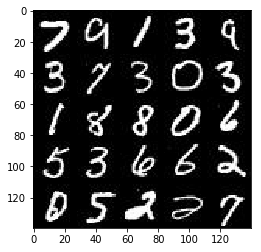

In [11]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import numpy as np

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

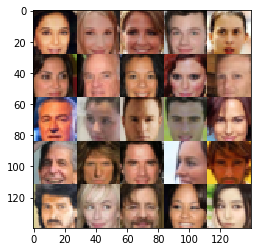

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


In [14]:
# from subprocess import check_output
# check_output(["nvidia-smi"])

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [15]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32)


    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    stddev = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        relu1 = tf.maximum(alpha * x1, x1)
        # ?x14x14x128 now
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # ?x7x7x128 now
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # ?x7x7x256 now

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        # ?x1 now

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    stddev = 0.1
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # ?x7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # ?x14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # ?x28x28x128 now  
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        # logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # ?x28x28x3 (if RGB) now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
import sys

def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real) * np.random.uniform(0.7, 1.1)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(
    epoch_count,
    batch_size,
    z_dim,
    learning_rate,
    beta1,
    get_batches,
    data_shape,
    data_image_mode,
    alpha,
    print_every,
    show_every
):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data, e.g., '60000, 28, 28, 1'
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # tf.reset_default_graph()
        
    input_real, input_z, learning_rate_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_tensor, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch_i in range(epoch_count):
            
            batch_numb = 0
            
            for batch_images in get_batches(batch_size):

                batch_numb += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(
                    d_opt, 
                    feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        learning_rate_tensor:
                        learning_rate
                    }
                )
                
                _ = sess.run(
                    g_opt,
                    feed_dict={
                        input_z: batch_z,
                        input_real: batch_images,
                        learning_rate_tensor: learning_rate
                    }
                )
                
                if batch_numb % print_every == 0:
                    # get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
            
                    print(
                        "Batch {}/{}...".format(batch_numb, data_shape[0]//batch_size),
                        "Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                        "Discriminator Loss: {:.4f}...".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g)
                    )
                    
                if batch_numb % show_every == 0:
                    show_generator_output(
                        sess,
                        25,
                        input_z,
                        data_shape[3],
                        data_image_mode
                    )
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Batch 10/937... Epoch 1/2... Discriminator Loss: 4.0071... Generator Loss: 0.0353
Batch 20/937... Epoch 1/2... Discriminator Loss: 3.3148... Generator Loss: 0.0765
Batch 30/937... Epoch 1/2... Discriminator Loss: 2.3069... Generator Loss: 0.1937
Batch 40/937... Epoch 1/2... Discriminator Loss: 2.2822... Generator Loss: 0.2276
Batch 50/937... Epoch 1/2... Discriminator Loss: 1.7871... Generator Loss: 0.3424
Batch 60/937... Epoch 1/2... Discriminator Loss: 1.6225... Generator Loss: 0.5116
Batch 70/937... Epoch 1/2... Discriminator Loss: 0.8635... Generator Loss: 1.1189
Batch 80/937... Epoch 1/2... Discriminator Loss: 1.8458... Generator Loss: 0.4344
Batch 90/937... Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 0.9498
Batch 100/937... Epoch 1/2... Discriminator Loss: 1.1490... Generator Loss: 0.7538


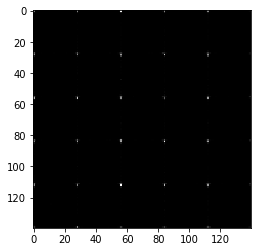

Batch 110/937... Epoch 1/2... Discriminator Loss: 0.7621... Generator Loss: 1.1275
Batch 120/937... Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 0.6651
Batch 130/937... Epoch 1/2... Discriminator Loss: 0.8688... Generator Loss: 1.0760
Batch 140/937... Epoch 1/2... Discriminator Loss: 0.8692... Generator Loss: 1.0239
Batch 150/937... Epoch 1/2... Discriminator Loss: 0.9369... Generator Loss: 0.9143
Batch 160/937... Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 0.9786
Batch 170/937... Epoch 1/2... Discriminator Loss: 0.7803... Generator Loss: 1.1826
Batch 180/937... Epoch 1/2... Discriminator Loss: 0.8225... Generator Loss: 1.0757
Batch 190/937... Epoch 1/2... Discriminator Loss: 0.9025... Generator Loss: 0.9028
Batch 200/937... Epoch 1/2... Discriminator Loss: 0.7232... Generator Loss: 1.3465


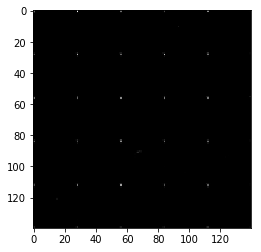

Batch 210/937... Epoch 1/2... Discriminator Loss: 0.8273... Generator Loss: 1.0260
Batch 220/937... Epoch 1/2... Discriminator Loss: 0.7043... Generator Loss: 1.4331
Batch 230/937... Epoch 1/2... Discriminator Loss: 0.6951... Generator Loss: 1.4938
Batch 240/937... Epoch 1/2... Discriminator Loss: 0.7109... Generator Loss: 1.2725
Batch 250/937... Epoch 1/2... Discriminator Loss: 0.6839... Generator Loss: 1.2495
Batch 260/937... Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 0.8797
Batch 270/937... Epoch 1/2... Discriminator Loss: 0.6206... Generator Loss: 1.6142
Batch 280/937... Epoch 1/2... Discriminator Loss: 0.7789... Generator Loss: 0.9680
Batch 290/937... Epoch 1/2... Discriminator Loss: 0.5717... Generator Loss: 1.4878
Batch 300/937... Epoch 1/2... Discriminator Loss: 0.5143... Generator Loss: 1.7034


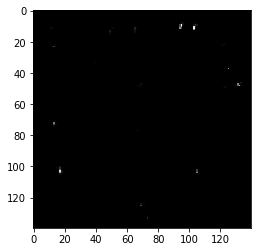

Batch 310/937... Epoch 1/2... Discriminator Loss: 0.6351... Generator Loss: 1.2426
Batch 320/937... Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 0.9990
Batch 330/937... Epoch 1/2... Discriminator Loss: 0.5711... Generator Loss: 1.3889
Batch 340/937... Epoch 1/2... Discriminator Loss: 0.7878... Generator Loss: 0.9667
Batch 350/937... Epoch 1/2... Discriminator Loss: 0.6883... Generator Loss: 1.1202
Batch 360/937... Epoch 1/2... Discriminator Loss: 0.5906... Generator Loss: 1.4725
Batch 370/937... Epoch 1/2... Discriminator Loss: 0.5022... Generator Loss: 2.7124
Batch 380/937... Epoch 1/2... Discriminator Loss: 0.4055... Generator Loss: 2.7443
Batch 390/937... Epoch 1/2... Discriminator Loss: 0.5149... Generator Loss: 3.6866
Batch 400/937... Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 2.6220


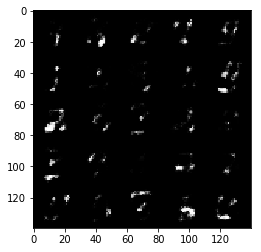

Batch 410/937... Epoch 1/2... Discriminator Loss: 0.6711... Generator Loss: 2.3369
Batch 420/937... Epoch 1/2... Discriminator Loss: 0.5199... Generator Loss: 2.0033
Batch 430/937... Epoch 1/2... Discriminator Loss: 2.7253... Generator Loss: 0.1030
Batch 440/937... Epoch 1/2... Discriminator Loss: 2.3845... Generator Loss: 0.1409
Batch 450/937... Epoch 1/2... Discriminator Loss: 0.3700... Generator Loss: 3.5082
Batch 460/937... Epoch 1/2... Discriminator Loss: 2.1229... Generator Loss: 0.4851
Batch 470/937... Epoch 1/2... Discriminator Loss: 1.6739... Generator Loss: 0.8187
Batch 480/937... Epoch 1/2... Discriminator Loss: 0.4696... Generator Loss: 4.1466
Batch 490/937... Epoch 1/2... Discriminator Loss: 0.6374... Generator Loss: 1.6987
Batch 500/937... Epoch 1/2... Discriminator Loss: 1.8853... Generator Loss: 0.6794


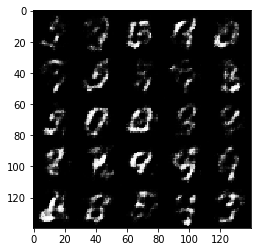

Batch 510/937... Epoch 1/2... Discriminator Loss: 1.8190... Generator Loss: 0.4757
Batch 520/937... Epoch 1/2... Discriminator Loss: 1.0386... Generator Loss: 0.7629
Batch 530/937... Epoch 1/2... Discriminator Loss: 0.7743... Generator Loss: 2.1748
Batch 540/937... Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 0.7363
Batch 550/937... Epoch 1/2... Discriminator Loss: 0.8610... Generator Loss: 0.9421
Batch 560/937... Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.6668
Batch 570/937... Epoch 1/2... Discriminator Loss: 1.2000... Generator Loss: 0.7707
Batch 580/937... Epoch 1/2... Discriminator Loss: 0.8494... Generator Loss: 1.2185
Batch 590/937... Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.7955
Batch 600/937... Epoch 1/2... Discriminator Loss: 0.9903... Generator Loss: 0.9668


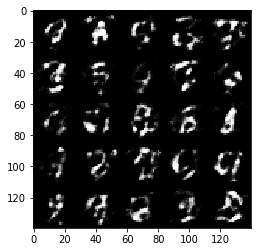

Batch 610/937... Epoch 1/2... Discriminator Loss: 0.9434... Generator Loss: 1.1686
Batch 620/937... Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 0.9886
Batch 630/937... Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 0.8055
Batch 640/937... Epoch 1/2... Discriminator Loss: 0.9728... Generator Loss: 1.0104
Batch 650/937... Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 0.8742
Batch 660/937... Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 0.8541
Batch 670/937... Epoch 1/2... Discriminator Loss: 0.9090... Generator Loss: 1.0989
Batch 680/937... Epoch 1/2... Discriminator Loss: 0.9810... Generator Loss: 0.9797
Batch 690/937... Epoch 1/2... Discriminator Loss: 0.9986... Generator Loss: 1.1998
Batch 700/937... Epoch 1/2... Discriminator Loss: 0.8551... Generator Loss: 1.0565


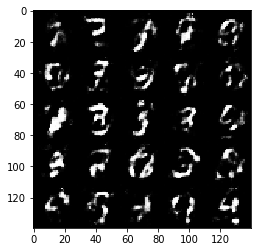

Batch 710/937... Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 0.7929
Batch 720/937... Epoch 1/2... Discriminator Loss: 0.9867... Generator Loss: 0.9413
Batch 730/937... Epoch 1/2... Discriminator Loss: 0.8137... Generator Loss: 1.1592
Batch 740/937... Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 0.8922
Batch 750/937... Epoch 1/2... Discriminator Loss: 0.8095... Generator Loss: 1.1520
Batch 760/937... Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 1.1459
Batch 770/937... Epoch 1/2... Discriminator Loss: 1.1003... Generator Loss: 0.7042
Batch 780/937... Epoch 1/2... Discriminator Loss: 0.8090... Generator Loss: 1.2775
Batch 790/937... Epoch 1/2... Discriminator Loss: 0.9033... Generator Loss: 1.0535
Batch 800/937... Epoch 1/2... Discriminator Loss: 0.8684... Generator Loss: 0.9880


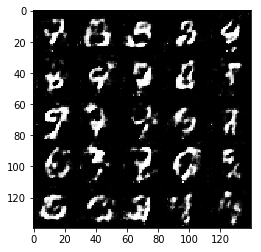

Batch 810/937... Epoch 1/2... Discriminator Loss: 0.8061... Generator Loss: 1.1621
Batch 820/937... Epoch 1/2... Discriminator Loss: 0.7589... Generator Loss: 1.2903
Batch 830/937... Epoch 1/2... Discriminator Loss: 0.8425... Generator Loss: 1.0965
Batch 840/937... Epoch 1/2... Discriminator Loss: 0.7092... Generator Loss: 1.5313
Batch 850/937... Epoch 1/2... Discriminator Loss: 0.6404... Generator Loss: 1.4945
Batch 860/937... Epoch 1/2... Discriminator Loss: 0.8462... Generator Loss: 1.1740
Batch 870/937... Epoch 1/2... Discriminator Loss: 0.8061... Generator Loss: 1.0962
Batch 880/937... Epoch 1/2... Discriminator Loss: 0.8074... Generator Loss: 1.4135
Batch 890/937... Epoch 1/2... Discriminator Loss: 0.8347... Generator Loss: 1.0621
Batch 900/937... Epoch 1/2... Discriminator Loss: 0.9293... Generator Loss: 0.8833


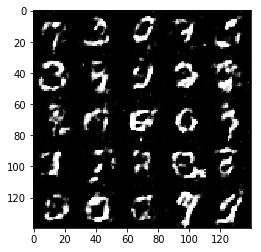

Batch 910/937... Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 0.7890
Batch 920/937... Epoch 1/2... Discriminator Loss: 0.6911... Generator Loss: 1.4581
Batch 930/937... Epoch 1/2... Discriminator Loss: 0.7624... Generator Loss: 1.1188
Batch 10/937... Epoch 2/2... Discriminator Loss: 0.7978... Generator Loss: 1.1454
Batch 20/937... Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 1.0444
Batch 30/937... Epoch 2/2... Discriminator Loss: 0.7407... Generator Loss: 1.1849
Batch 40/937... Epoch 2/2... Discriminator Loss: 0.6208... Generator Loss: 1.7956
Batch 50/937... Epoch 2/2... Discriminator Loss: 0.6333... Generator Loss: 1.5599
Batch 60/937... Epoch 2/2... Discriminator Loss: 0.8051... Generator Loss: 1.2549
Batch 70/937... Epoch 2/2... Discriminator Loss: 0.8618... Generator Loss: 0.9710
Batch 80/937... Epoch 2/2... Discriminator Loss: 0.6784... Generator Loss: 1.1938
Batch 90/937... Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.5496
Batch 100/937

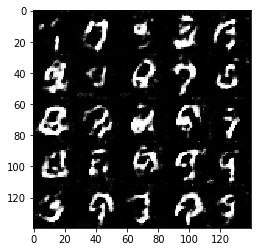

Batch 110/937... Epoch 2/2... Discriminator Loss: 0.3852... Generator Loss: 2.4728
Batch 120/937... Epoch 2/2... Discriminator Loss: 0.6392... Generator Loss: 1.7210
Batch 130/937... Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 0.9145
Batch 140/937... Epoch 2/2... Discriminator Loss: 0.5911... Generator Loss: 1.9142
Batch 150/937... Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 1.5464
Batch 160/937... Epoch 2/2... Discriminator Loss: 0.8483... Generator Loss: 1.3283
Batch 170/937... Epoch 2/2... Discriminator Loss: 0.5557... Generator Loss: 1.5205
Batch 180/937... Epoch 2/2... Discriminator Loss: 0.8236... Generator Loss: 1.0219
Batch 190/937... Epoch 2/2... Discriminator Loss: 0.6359... Generator Loss: 1.4660
Batch 200/937... Epoch 2/2... Discriminator Loss: 0.5912... Generator Loss: 2.1294


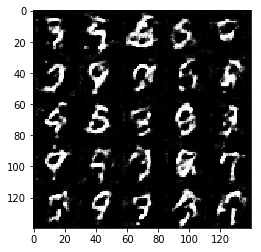

Batch 210/937... Epoch 2/2... Discriminator Loss: 0.4497... Generator Loss: 2.0694
Batch 220/937... Epoch 2/2... Discriminator Loss: 0.6642... Generator Loss: 1.7284
Batch 230/937... Epoch 2/2... Discriminator Loss: 0.8167... Generator Loss: 1.8893
Batch 240/937... Epoch 2/2... Discriminator Loss: 0.6131... Generator Loss: 1.6593
Batch 250/937... Epoch 2/2... Discriminator Loss: 1.0740... Generator Loss: 0.6820
Batch 260/937... Epoch 2/2... Discriminator Loss: 0.8249... Generator Loss: 1.1658
Batch 270/937... Epoch 2/2... Discriminator Loss: 0.6172... Generator Loss: 2.3185
Batch 280/937... Epoch 2/2... Discriminator Loss: 1.1594... Generator Loss: 0.6400
Batch 290/937... Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 0.4869
Batch 300/937... Epoch 2/2... Discriminator Loss: 0.5829... Generator Loss: 1.6574


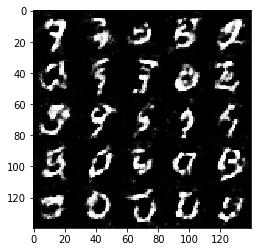

Batch 310/937... Epoch 2/2... Discriminator Loss: 0.9658... Generator Loss: 0.9404
Batch 320/937... Epoch 2/2... Discriminator Loss: 0.7349... Generator Loss: 1.2317
Batch 330/937... Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 1.5765
Batch 340/937... Epoch 2/2... Discriminator Loss: 0.7800... Generator Loss: 1.0769
Batch 350/937... Epoch 2/2... Discriminator Loss: 0.7527... Generator Loss: 1.1599
Batch 360/937... Epoch 2/2... Discriminator Loss: 0.6544... Generator Loss: 1.3377
Batch 370/937... Epoch 2/2... Discriminator Loss: 0.6933... Generator Loss: 1.3826
Batch 380/937... Epoch 2/2... Discriminator Loss: 0.9090... Generator Loss: 0.9159
Batch 390/937... Epoch 2/2... Discriminator Loss: 0.8502... Generator Loss: 1.0492
Batch 400/937... Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 0.7740


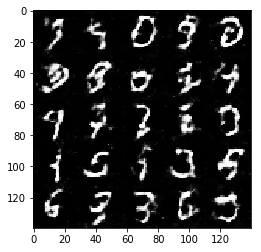

Batch 410/937... Epoch 2/2... Discriminator Loss: 0.7580... Generator Loss: 1.2360
Batch 420/937... Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.0057
Batch 430/937... Epoch 2/2... Discriminator Loss: 0.8465... Generator Loss: 1.5851
Batch 440/937... Epoch 2/2... Discriminator Loss: 0.7468... Generator Loss: 1.1328
Batch 450/937... Epoch 2/2... Discriminator Loss: 0.5183... Generator Loss: 2.0036
Batch 460/937... Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 0.5330
Batch 470/937... Epoch 2/2... Discriminator Loss: 0.8633... Generator Loss: 1.5760
Batch 480/937... Epoch 2/2... Discriminator Loss: 0.6737... Generator Loss: 1.1892
Batch 490/937... Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 0.7785
Batch 500/937... Epoch 2/2... Discriminator Loss: 0.8951... Generator Loss: 1.3752


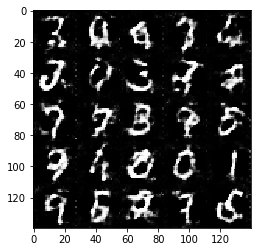

Batch 510/937... Epoch 2/2... Discriminator Loss: 0.7613... Generator Loss: 1.7334
Batch 520/937... Epoch 2/2... Discriminator Loss: 0.4916... Generator Loss: 2.1876
Batch 530/937... Epoch 2/2... Discriminator Loss: 0.9302... Generator Loss: 0.8205
Batch 540/937... Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 1.4769
Batch 550/937... Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 0.8085
Batch 560/937... Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.6223
Batch 570/937... Epoch 2/2... Discriminator Loss: 0.9258... Generator Loss: 0.9356
Batch 580/937... Epoch 2/2... Discriminator Loss: 0.8968... Generator Loss: 1.0762
Batch 590/937... Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 0.4338
Batch 600/937... Epoch 2/2... Discriminator Loss: 0.9581... Generator Loss: 0.8647


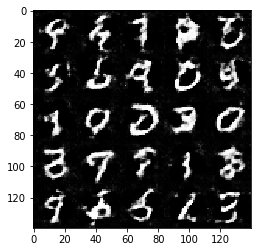

Batch 610/937... Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 0.8403
Batch 620/937... Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 0.8829
Batch 630/937... Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 1.3176
Batch 640/937... Epoch 2/2... Discriminator Loss: 0.6054... Generator Loss: 1.4723
Batch 650/937... Epoch 2/2... Discriminator Loss: 1.1095... Generator Loss: 0.7307
Batch 660/937... Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 0.6659
Batch 670/937... Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 0.9465
Batch 680/937... Epoch 2/2... Discriminator Loss: 0.5169... Generator Loss: 2.1035
Batch 690/937... Epoch 2/2... Discriminator Loss: 0.8538... Generator Loss: 1.1249
Batch 700/937... Epoch 2/2... Discriminator Loss: 1.0899... Generator Loss: 0.8245


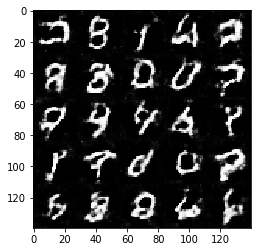

Batch 710/937... Epoch 2/2... Discriminator Loss: 1.5872... Generator Loss: 0.3609
Batch 720/937... Epoch 2/2... Discriminator Loss: 0.9439... Generator Loss: 0.8561
Batch 730/937... Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 0.8254
Batch 740/937... Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 0.5574
Batch 750/937... Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 0.9324
Batch 760/937... Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 1.5378
Batch 770/937... Epoch 2/2... Discriminator Loss: 1.1755... Generator Loss: 0.6675
Batch 780/937... Epoch 2/2... Discriminator Loss: 0.8529... Generator Loss: 1.0908
Batch 790/937... Epoch 2/2... Discriminator Loss: 0.9720... Generator Loss: 0.9764
Batch 800/937... Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 0.7673


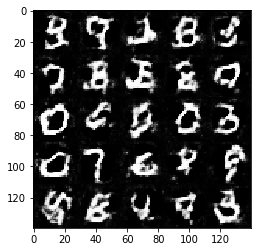

Batch 810/937... Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 1.3352
Batch 820/937... Epoch 2/2... Discriminator Loss: 0.9616... Generator Loss: 1.2991
Batch 830/937... Epoch 2/2... Discriminator Loss: 0.9844... Generator Loss: 0.9828
Batch 840/937... Epoch 2/2... Discriminator Loss: 0.7644... Generator Loss: 1.3478
Batch 850/937... Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 1.2802
Batch 860/937... Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 1.1768
Batch 870/937... Epoch 2/2... Discriminator Loss: 0.9530... Generator Loss: 0.9273
Batch 880/937... Epoch 2/2... Discriminator Loss: 1.1486... Generator Loss: 1.5473
Batch 890/937... Epoch 2/2... Discriminator Loss: 1.2679... Generator Loss: 1.2544
Batch 900/937... Epoch 2/2... Discriminator Loss: 1.0508... Generator Loss: 0.7924


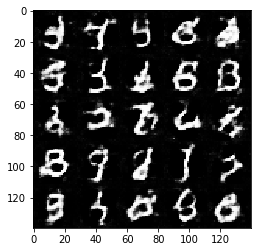

Batch 910/937... Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 0.8535
Batch 920/937... Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 1.0815
Batch 930/937... Epoch 2/2... Discriminator Loss: 0.8142... Generator Loss: 1.1003


In [22]:
import sys

batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha=0.2
print_every=10
show_every=100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(
        epochs,
        batch_size,
        z_dim,
        learning_rate,
        beta1,
        mnist_dataset.get_batches,
        mnist_dataset.shape,
        mnist_dataset.image_mode,
        alpha,
        print_every,
        show_every
    )

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Batch 10/6331... Epoch 1/1... Discriminator Loss: 5.9961... Generator Loss: 0.0060
Batch 20/6331... Epoch 1/1... Discriminator Loss: 6.2676... Generator Loss: 0.0046
Batch 30/6331... Epoch 1/1... Discriminator Loss: 5.3826... Generator Loss: 0.0161
Batch 40/6331... Epoch 1/1... Discriminator Loss: 4.6326... Generator Loss: 0.0236
Batch 50/6331... Epoch 1/1... Discriminator Loss: 4.2762... Generator Loss: 0.0292
Batch 60/6331... Epoch 1/1... Discriminator Loss: 3.5845... Generator Loss: 0.0744
Batch 70/6331... Epoch 1/1... Discriminator Loss: 2.9902... Generator Loss: 0.1096
Batch 80/6331... Epoch 1/1... Discriminator Loss: 2.7281... Generator Loss: 0.1837
Batch 90/6331... Epoch 1/1... Discriminator Loss: 2.7025... Generator Loss: 0.1594
Batch 100/6331... Epoch 1/1... Discriminator Loss: 2.2515... Generator Loss: 0.2974


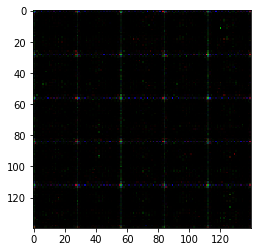

Batch 110/6331... Epoch 1/1... Discriminator Loss: 1.8397... Generator Loss: 0.3606
Batch 120/6331... Epoch 1/1... Discriminator Loss: 1.7846... Generator Loss: 0.4064
Batch 130/6331... Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.6208
Batch 140/6331... Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.8372
Batch 150/6331... Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.8169
Batch 160/6331... Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 1.0328
Batch 170/6331... Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7387
Batch 180/6331... Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.1175
Batch 190/6331... Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.2593
Batch 200/6331... Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.8839


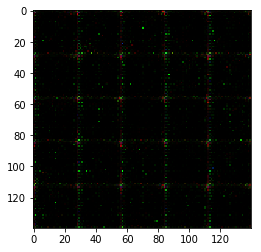

Batch 210/6331... Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 1.4309
Batch 220/6331... Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.3305
Batch 230/6331... Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 1.3566
Batch 240/6331... Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 1.9950
Batch 250/6331... Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.8045
Batch 260/6331... Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 3.0401
Batch 270/6331... Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 2.5395
Batch 280/6331... Epoch 1/1... Discriminator Loss: 0.7054... Generator Loss: 1.9441
Batch 290/6331... Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 2.5188
Batch 300/6331... Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 1.9108


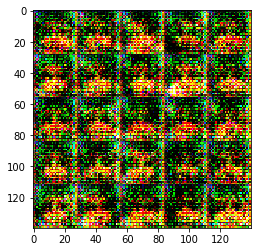

Batch 310/6331... Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 1.9674
Batch 320/6331... Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 1.9010
Batch 330/6331... Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 1.7488
Batch 340/6331... Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 2.8551
Batch 350/6331... Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 2.7731
Batch 360/6331... Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 2.5560
Batch 370/6331... Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 3.0055
Batch 380/6331... Epoch 1/1... Discriminator Loss: 0.5223... Generator Loss: 3.2728
Batch 390/6331... Epoch 1/1... Discriminator Loss: 0.5581... Generator Loss: 2.7633
Batch 400/6331... Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 3.0411


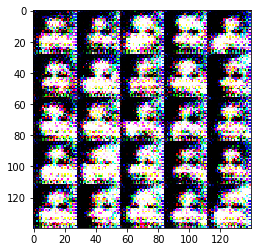

Batch 410/6331... Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 2.9086
Batch 420/6331... Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 2.6780
Batch 430/6331... Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 2.5312
Batch 440/6331... Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 2.4238
Batch 450/6331... Epoch 1/1... Discriminator Loss: 0.6523... Generator Loss: 2.1264
Batch 460/6331... Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.9980
Batch 470/6331... Epoch 1/1... Discriminator Loss: 0.5300... Generator Loss: 3.0317
Batch 480/6331... Epoch 1/1... Discriminator Loss: 0.5668... Generator Loss: 2.6517
Batch 490/6331... Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 2.7647
Batch 500/6331... Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 2.6075


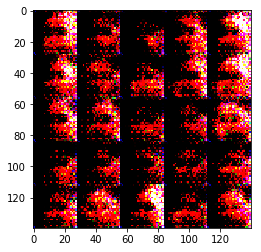

Batch 510/6331... Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 3.0347
Batch 520/6331... Epoch 1/1... Discriminator Loss: 0.5485... Generator Loss: 2.8588
Batch 530/6331... Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 2.9338
Batch 540/6331... Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 2.0761
Batch 550/6331... Epoch 1/1... Discriminator Loss: 0.5277... Generator Loss: 3.1522
Batch 560/6331... Epoch 1/1... Discriminator Loss: 0.5664... Generator Loss: 2.8681
Batch 570/6331... Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 2.3383
Batch 580/6331... Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 2.5341
Batch 590/6331... Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 3.0263
Batch 600/6331... Epoch 1/1... Discriminator Loss: 0.5298... Generator Loss: 3.1571


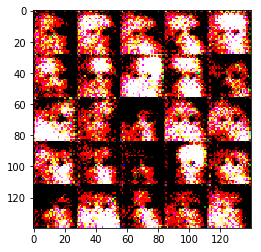

Batch 610/6331... Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 2.4265
Batch 620/6331... Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 2.8688
Batch 630/6331... Epoch 1/1... Discriminator Loss: 0.5672... Generator Loss: 2.6659
Batch 640/6331... Epoch 1/1... Discriminator Loss: 0.5777... Generator Loss: 2.5015
Batch 650/6331... Epoch 1/1... Discriminator Loss: 0.5319... Generator Loss: 3.2790
Batch 660/6331... Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 2.7915
Batch 670/6331... Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 2.4059
Batch 680/6331... Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 2.6358
Batch 690/6331... Epoch 1/1... Discriminator Loss: 0.5406... Generator Loss: 3.0937
Batch 700/6331... Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 2.0398


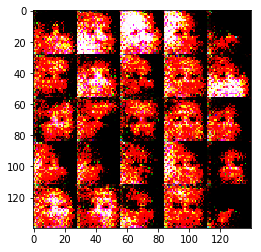

Batch 710/6331... Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 2.7283
Batch 720/6331... Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 2.3895
Batch 730/6331... Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 2.5322
Batch 740/6331... Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 3.3835
Batch 750/6331... Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 2.6807
Batch 760/6331... Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 2.4691
Batch 770/6331... Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 3.7004
Batch 780/6331... Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 3.8161
Batch 790/6331... Epoch 1/1... Discriminator Loss: 0.5083... Generator Loss: 3.7668
Batch 800/6331... Epoch 1/1... Discriminator Loss: 0.5280... Generator Loss: 3.4764


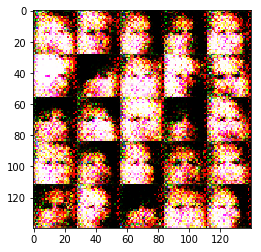

Batch 810/6331... Epoch 1/1... Discriminator Loss: 0.5104... Generator Loss: 3.5592
Batch 820/6331... Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 3.6096
Batch 830/6331... Epoch 1/1... Discriminator Loss: 0.5577... Generator Loss: 2.8211
Batch 840/6331... Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 3.9300
Batch 850/6331... Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 2.4382
Batch 860/6331... Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 4.1354
Batch 870/6331... Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 2.5183
Batch 880/6331... Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 2.8601
Batch 890/6331... Epoch 1/1... Discriminator Loss: 0.5379... Generator Loss: 4.5281
Batch 900/6331... Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 5.0123


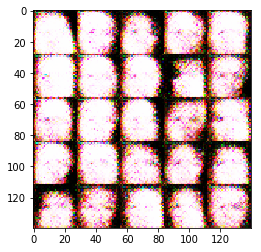

Batch 910/6331... Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 3.3666
Batch 920/6331... Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.8561
Batch 930/6331... Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 5.0179
Batch 940/6331... Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 3.5286
Batch 950/6331... Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 4.7367
Batch 960/6331... Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 4.7685
Batch 970/6331... Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 3.4757
Batch 980/6331... Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 2.6399
Batch 990/6331... Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 3.1386
Batch 1000/6331... Epoch 1/1... Discriminator Loss: 0.5652... Generator Loss: 4.6573


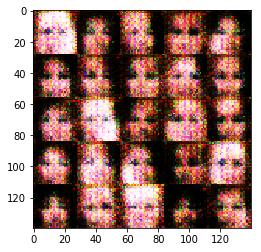

Batch 1010/6331... Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 6.3507
Batch 1020/6331... Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 2.6133
Batch 1030/6331... Epoch 1/1... Discriminator Loss: 0.5735... Generator Loss: 2.9139
Batch 1040/6331... Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 2.5475
Batch 1050/6331... Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.9490
Batch 1060/6331... Epoch 1/1... Discriminator Loss: 0.5585... Generator Loss: 2.8991
Batch 1070/6331... Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 1.9519
Batch 1080/6331... Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 3.0287
Batch 1090/6331... Epoch 1/1... Discriminator Loss: 0.5232... Generator Loss: 3.4254
Batch 1100/6331... Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 3.5629


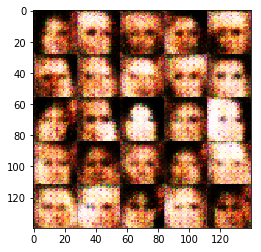

Batch 1110/6331... Epoch 1/1... Discriminator Loss: 0.4957... Generator Loss: 6.1092
Batch 1120/6331... Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 4.0189
Batch 1130/6331... Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 4.8803
Batch 1140/6331... Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 5.1257
Batch 1150/6331... Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.1528
Batch 1160/6331... Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 4.7236
Batch 1170/6331... Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 2.7588
Batch 1180/6331... Epoch 1/1... Discriminator Loss: 0.5105... Generator Loss: 3.7129
Batch 1190/6331... Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 3.6708
Batch 1200/6331... Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 3.7398


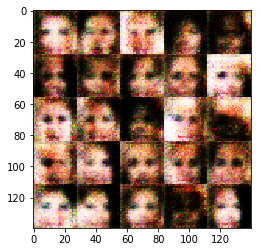

Batch 1210/6331... Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.8023
Batch 1220/6331... Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 6.8462
Batch 1230/6331... Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 6.2736
Batch 1240/6331... Epoch 1/1... Discriminator Loss: 0.4915... Generator Loss: 5.4094
Batch 1250/6331... Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 2.3234
Batch 1260/6331... Epoch 1/1... Discriminator Loss: 0.5857... Generator Loss: 3.1882
Batch 1270/6331... Epoch 1/1... Discriminator Loss: 0.5742... Generator Loss: 4.4470
Batch 1280/6331... Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.3069
Batch 1290/6331... Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 5.4241
Batch 1300/6331... Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 1.0316


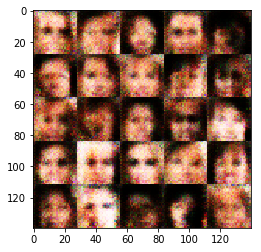

Batch 1310/6331... Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 4.4061
Batch 1320/6331... Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 5.9934
Batch 1330/6331... Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 7.4024
Batch 1340/6331... Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 4.6177
Batch 1350/6331... Epoch 1/1... Discriminator Loss: 0.4852... Generator Loss: 6.1699
Batch 1360/6331... Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 4.1475
Batch 1370/6331... Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 11.3830
Batch 1380/6331... Epoch 1/1... Discriminator Loss: 0.4781... Generator Loss: 7.6961
Batch 1390/6331... Epoch 1/1... Discriminator Loss: 0.5525... Generator Loss: 4.4557
Batch 1400/6331... Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.2963


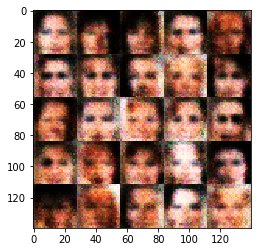

Batch 1410/6331... Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 11.7176
Batch 1420/6331... Epoch 1/1... Discriminator Loss: 0.5094... Generator Loss: 3.6868
Batch 1430/6331... Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 4.5379
Batch 1440/6331... Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 7.1266
Batch 1450/6331... Epoch 1/1... Discriminator Loss: 0.4941... Generator Loss: 4.5730
Batch 1460/6331... Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 8.7767
Batch 1470/6331... Epoch 1/1... Discriminator Loss: 1.6061... Generator Loss: 0.5410
Batch 1480/6331... Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 7.0115
Batch 1490/6331... Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 2.7074
Batch 1500/6331... Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 1.9935


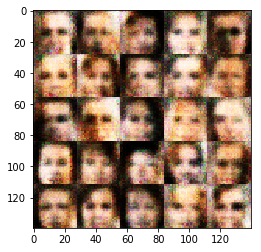

Batch 1510/6331... Epoch 1/1... Discriminator Loss: 0.5882... Generator Loss: 2.8522
Batch 1520/6331... Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 2.6326
Batch 1530/6331... Epoch 1/1... Discriminator Loss: 0.6257... Generator Loss: 2.7426
Batch 1540/6331... Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 2.0906
Batch 1550/6331... Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 7.2830
Batch 1560/6331... Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.3514
Batch 1570/6331... Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 7.8517
Batch 1580/6331... Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 3.2272
Batch 1590/6331... Epoch 1/1... Discriminator Loss: 0.6546... Generator Loss: 3.1790
Batch 1600/6331... Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 12.5453


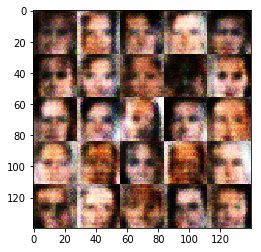

Batch 1610/6331... Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 3.1134
Batch 1620/6331... Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 8.3148
Batch 1630/6331... Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.3519
Batch 1640/6331... Epoch 1/1... Discriminator Loss: 0.4949... Generator Loss: 4.5310
Batch 1650/6331... Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 2.5203
Batch 1660/6331... Epoch 1/1... Discriminator Loss: 0.5519... Generator Loss: 5.1981
Batch 1670/6331... Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 3.4157
Batch 1680/6331... Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 11.0863
Batch 1690/6331... Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 3.0173
Batch 1700/6331... Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 7.5725


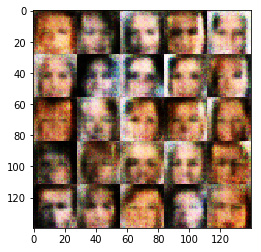

Batch 1710/6331... Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.9925
Batch 1720/6331... Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 4.7011
Batch 1730/6331... Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.8115
Batch 1740/6331... Epoch 1/1... Discriminator Loss: 2.0216... Generator Loss: 0.2828
Batch 1750/6331... Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 10.4750
Batch 1760/6331... Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 10.3706
Batch 1770/6331... Epoch 1/1... Discriminator Loss: 2.2310... Generator Loss: 0.2477
Batch 1780/6331... Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.9672
Batch 1790/6331... Epoch 1/1... Discriminator Loss: 0.4845... Generator Loss: 11.3567
Batch 1800/6331... Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 7.1972


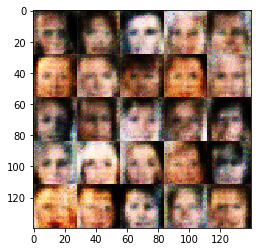

Batch 1810/6331... Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 4.2080
Batch 1820/6331... Epoch 1/1... Discriminator Loss: 0.5237... Generator Loss: 6.7303
Batch 1830/6331... Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 11.1565
Batch 1840/6331... Epoch 1/1... Discriminator Loss: 1.9216... Generator Loss: 0.3298
Batch 1850/6331... Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 6.3867
Batch 1860/6331... Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 10.0286
Batch 1870/6331... Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.8043
Batch 1880/6331... Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.4392
Batch 1890/6331... Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 11.2576
Batch 1900/6331... Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 3.5610


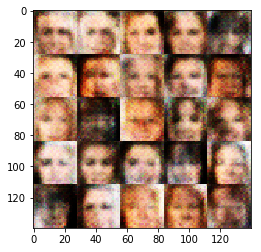

Batch 1910/6331... Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 10.2678
Batch 1920/6331... Epoch 1/1... Discriminator Loss: 0.5155... Generator Loss: 3.4417
Batch 1930/6331... Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 4.5877
Batch 1940/6331... Epoch 1/1... Discriminator Loss: 0.6044... Generator Loss: 2.6687
Batch 1950/6331... Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 2.2147
Batch 1960/6331... Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 6.1656
Batch 1970/6331... Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 3.1967
Batch 1980/6331... Epoch 1/1... Discriminator Loss: 2.1947... Generator Loss: 0.2744
Batch 1990/6331... Epoch 1/1... Discriminator Loss: 0.5638... Generator Loss: 4.5171
Batch 2000/6331... Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 2.5147


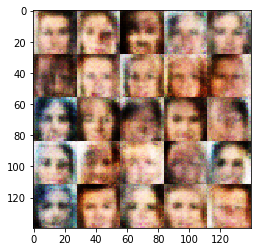

Batch 2010/6331... Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 2.2306
Batch 2020/6331... Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 12.0426
Batch 2030/6331... Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 2.1653
Batch 2040/6331... Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 3.0787
Batch 2050/6331... Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.6573
Batch 2060/6331... Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 8.9614
Batch 2070/6331... Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.9755
Batch 2080/6331... Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 8.9868
Batch 2090/6331... Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 2.2544
Batch 2100/6331... Epoch 1/1... Discriminator Loss: 0.5047... Generator Loss: 4.5915


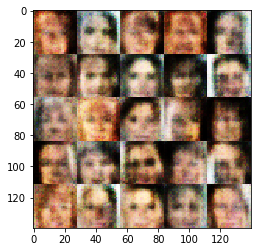

Batch 2110/6331... Epoch 1/1... Discriminator Loss: 0.4794... Generator Loss: 6.9102
Batch 2120/6331... Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 2.4754
Batch 2130/6331... Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 3.5366
Batch 2140/6331... Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.6652
Batch 2150/6331... Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 12.5185
Batch 2160/6331... Epoch 1/1... Discriminator Loss: 0.5632... Generator Loss: 8.5058
Batch 2170/6331... Epoch 1/1... Discriminator Loss: 0.4693... Generator Loss: 8.1341
Batch 2180/6331... Epoch 1/1... Discriminator Loss: 0.5464... Generator Loss: 2.8019
Batch 2190/6331... Epoch 1/1... Discriminator Loss: 0.4813... Generator Loss: 4.9157
Batch 2200/6331... Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 1.3272


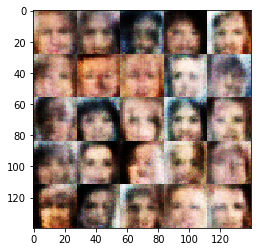

Batch 2210/6331... Epoch 1/1... Discriminator Loss: 0.4881... Generator Loss: 8.9163
Batch 2220/6331... Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 1.7619
Batch 2230/6331... Epoch 1/1... Discriminator Loss: 0.4720... Generator Loss: 9.0813
Batch 2240/6331... Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 13.7880
Batch 2250/6331... Epoch 1/1... Discriminator Loss: 0.6969... Generator Loss: 6.9712
Batch 2260/6331... Epoch 1/1... Discriminator Loss: 0.4726... Generator Loss: 13.5191
Batch 2270/6331... Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 6.9095
Batch 2280/6331... Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 4.7448
Batch 2290/6331... Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 7.9870
Batch 2300/6331... Epoch 1/1... Discriminator Loss: 0.4822... Generator Loss: 4.8942


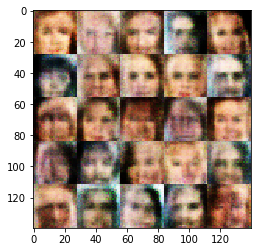

Batch 2310/6331... Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 10.5528
Batch 2320/6331... Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.5708
Batch 2330/6331... Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 5.0845
Batch 2340/6331... Epoch 1/1... Discriminator Loss: 0.5486... Generator Loss: 5.8871
Batch 2350/6331... Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 1.6451
Batch 2360/6331... Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 1.3658
Batch 2370/6331... Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.4853
Batch 2380/6331... Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 5.3380
Batch 2390/6331... Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 2.0593
Batch 2400/6331... Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 5.0618


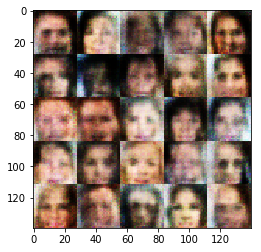

Batch 2410/6331... Epoch 1/1... Discriminator Loss: 0.4887... Generator Loss: 4.4954
Batch 2420/6331... Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 7.1560
Batch 2430/6331... Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.5842
Batch 2440/6331... Epoch 1/1... Discriminator Loss: 0.5280... Generator Loss: 10.7290
Batch 2450/6331... Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 6.0812
Batch 2460/6331... Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 6.9063
Batch 2470/6331... Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.3217
Batch 2480/6331... Epoch 1/1... Discriminator Loss: 0.6433... Generator Loss: 2.0020
Batch 2490/6331... Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 3.9799
Batch 2500/6331... Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6386


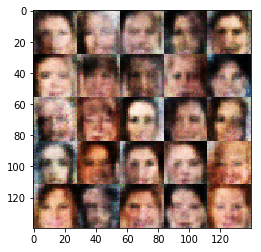

Batch 2510/6331... Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 1.5933
Batch 2520/6331... Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 4.6655
Batch 2530/6331... Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 2.8917
Batch 2540/6331... Epoch 1/1... Discriminator Loss: 0.4749... Generator Loss: 5.2121
Batch 2550/6331... Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 2.4579
Batch 2560/6331... Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 2.9285
Batch 2570/6331... Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 6.7729
Batch 2580/6331... Epoch 1/1... Discriminator Loss: 1.6522... Generator Loss: 0.4511
Batch 2590/6331... Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 5.7258
Batch 2600/6331... Epoch 1/1... Discriminator Loss: 1.7275... Generator Loss: 0.4248


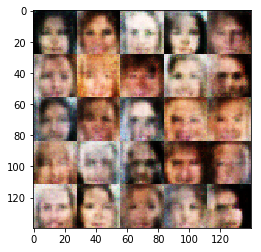

Batch 2610/6331... Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.4564
Batch 2620/6331... Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 8.0637
Batch 2630/6331... Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.0914
Batch 2640/6331... Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 3.4089
Batch 2650/6331... Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 3.7704
Batch 2660/6331... Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 5.8294
Batch 2670/6331... Epoch 1/1... Discriminator Loss: 0.5350... Generator Loss: 3.0136
Batch 2680/6331... Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 5.4588
Batch 2690/6331... Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 4.7385
Batch 2700/6331... Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 2.8595


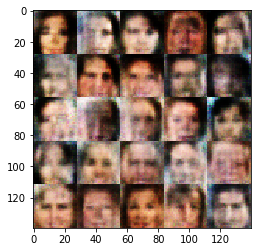

Batch 2710/6331... Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 6.9083
Batch 2720/6331... Epoch 1/1... Discriminator Loss: 0.5530... Generator Loss: 6.6800
Batch 2730/6331... Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 6.8538
Batch 2740/6331... Epoch 1/1... Discriminator Loss: 0.5025... Generator Loss: 4.4659
Batch 2750/6331... Epoch 1/1... Discriminator Loss: 1.5873... Generator Loss: 0.4381
Batch 2760/6331... Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 7.0433
Batch 2770/6331... Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 2.0489
Batch 2780/6331... Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 5.1407
Batch 2790/6331... Epoch 1/1... Discriminator Loss: 0.5776... Generator Loss: 3.2201
Batch 2800/6331... Epoch 1/1... Discriminator Loss: 0.4730... Generator Loss: 11.9944


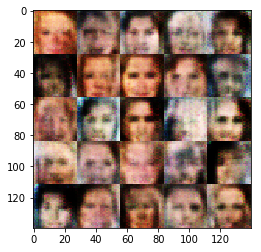

Batch 2810/6331... Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 3.6820
Batch 2820/6331... Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 4.9242
Batch 2830/6331... Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 3.1879
Batch 2840/6331... Epoch 1/1... Discriminator Loss: 0.4773... Generator Loss: 6.1332
Batch 2850/6331... Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 4.7927
Batch 2860/6331... Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 3.6949
Batch 2870/6331... Epoch 1/1... Discriminator Loss: 0.4768... Generator Loss: 7.0852
Batch 2880/6331... Epoch 1/1... Discriminator Loss: 0.5025... Generator Loss: 4.2024
Batch 2890/6331... Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 6.8077
Batch 2900/6331... Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 3.4879


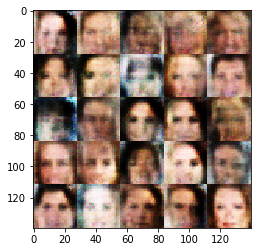

Batch 2910/6331... Epoch 1/1... Discriminator Loss: 0.5574... Generator Loss: 3.6541
Batch 2920/6331... Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 6.6257
Batch 2930/6331... Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.9583
Batch 2940/6331... Epoch 1/1... Discriminator Loss: 0.4729... Generator Loss: 5.1569
Batch 2950/6331... Epoch 1/1... Discriminator Loss: 0.4961... Generator Loss: 8.0910
Batch 2960/6331... Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 9.9812
Batch 2970/6331... Epoch 1/1... Discriminator Loss: 0.6295... Generator Loss: 3.1759
Batch 2980/6331... Epoch 1/1... Discriminator Loss: 0.6565... Generator Loss: 2.5022
Batch 2990/6331... Epoch 1/1... Discriminator Loss: 0.5561... Generator Loss: 10.8107
Batch 3000/6331... Epoch 1/1... Discriminator Loss: 0.4811... Generator Loss: 6.5862


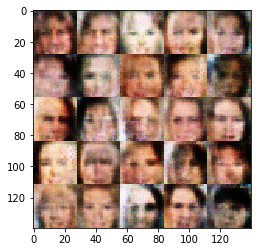

Batch 3010/6331... Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 10.1654
Batch 3020/6331... Epoch 1/1... Discriminator Loss: 0.5096... Generator Loss: 4.4577
Batch 3030/6331... Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 5.2378
Batch 3040/6331... Epoch 1/1... Discriminator Loss: 0.4823... Generator Loss: 7.8394
Batch 3050/6331... Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 3.5363
Batch 3060/6331... Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 5.2916
Batch 3070/6331... Epoch 1/1... Discriminator Loss: 0.5405... Generator Loss: 3.9291
Batch 3080/6331... Epoch 1/1... Discriminator Loss: 0.5384... Generator Loss: 3.4332
Batch 3090/6331... Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 6.1078
Batch 3100/6331... Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.7073


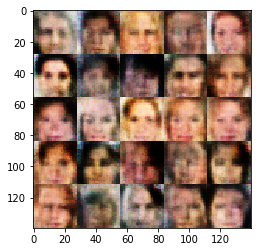

Batch 3110/6331... Epoch 1/1... Discriminator Loss: 0.4846... Generator Loss: 6.0821
Batch 3120/6331... Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 1.0791
Batch 3130/6331... Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 5.0233
Batch 3140/6331... Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 3.7499
Batch 3150/6331... Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 2.4962
Batch 3160/6331... Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 3.2495
Batch 3170/6331... Epoch 1/1... Discriminator Loss: 0.5561... Generator Loss: 3.2047
Batch 3180/6331... Epoch 1/1... Discriminator Loss: 0.6102... Generator Loss: 2.4337
Batch 3190/6331... Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 10.2983
Batch 3200/6331... Epoch 1/1... Discriminator Loss: 0.4964... Generator Loss: 5.4410


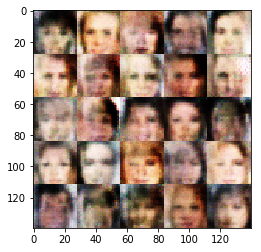

Batch 3210/6331... Epoch 1/1... Discriminator Loss: 0.4849... Generator Loss: 4.8571
Batch 3220/6331... Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 5.9311
Batch 3230/6331... Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 4.4298
Batch 3240/6331... Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 9.9435
Batch 4530/6331... Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 3.0433
Batch 4540/6331... Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 3.5735
Batch 4550/6331... Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 5.7829
Batch 4560/6331... Epoch 1/1... Discriminator Loss: 0.5464... Generator Loss: 3.8141
Batch 4570/6331... Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 2.1284
Batch 4580/6331... Epoch 1/1... Discriminator Loss: 0.4810... Generator Loss: 5.8197
Batch 4590/6331... Epoch 1/1... Discriminator Loss: 0.4703... Generator Loss: 5.9319
Batch 4600/6331... Epoch 1/1... Discriminator Loss: 0.6593... Gen

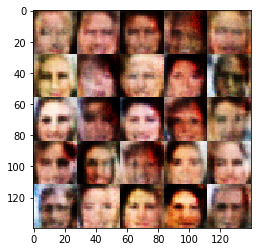

Batch 4610/6331... Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 6.0900
Batch 4620/6331... Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 3.6515
Batch 4630/6331... Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 4.6738
Batch 4640/6331... Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 5.9057
Batch 4650/6331... Epoch 1/1... Discriminator Loss: 0.4908... Generator Loss: 8.3199
Batch 4660/6331... Epoch 1/1... Discriminator Loss: 0.5006... Generator Loss: 6.2521
Batch 4670/6331... Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 11.0187
Batch 4680/6331... Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 6.6596
Batch 4690/6331... Epoch 1/1... Discriminator Loss: 0.4822... Generator Loss: 5.0672
Batch 4700/6331... Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 8.2956


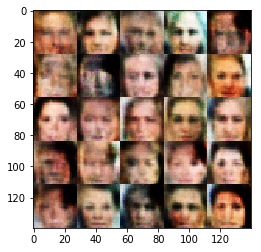

Batch 4710/6331... Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 6.2863
Batch 4720/6331... Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 5.0587
Batch 4730/6331... Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 4.7671
Batch 4740/6331... Epoch 1/1... Discriminator Loss: 0.5343... Generator Loss: 4.0386
Batch 4750/6331... Epoch 1/1... Discriminator Loss: 0.4691... Generator Loss: 7.3852
Batch 4760/6331... Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 3.6895
Batch 4770/6331... Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 4.6054
Batch 4780/6331... Epoch 1/1... Discriminator Loss: 0.4851... Generator Loss: 8.2668
Batch 4790/6331... Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 2.4669
Batch 4800/6331... Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 7.0547


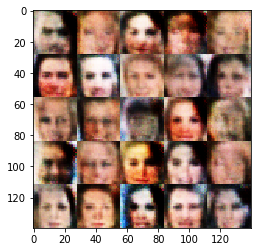

Batch 4810/6331... Epoch 1/1... Discriminator Loss: 0.4957... Generator Loss: 4.8394
Batch 4820/6331... Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 4.3672
Batch 4830/6331... Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 4.4069
Batch 4840/6331... Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 6.6727
Batch 4850/6331... Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 4.5622
Batch 4860/6331... Epoch 1/1... Discriminator Loss: 0.5394... Generator Loss: 4.6116
Batch 4870/6331... Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 4.9108
Batch 4880/6331... Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 6.2500
Batch 4890/6331... Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 2.7242
Batch 4900/6331... Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 6.8185


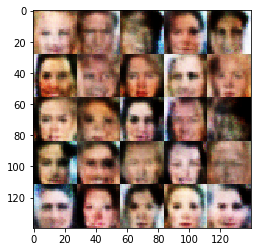

Batch 4910/6331... Epoch 1/1... Discriminator Loss: 0.5939... Generator Loss: 2.6699
Batch 4920/6331... Epoch 1/1... Discriminator Loss: 0.4760... Generator Loss: 4.7251
Batch 4930/6331... Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 1.2948
Batch 4940/6331... Epoch 1/1... Discriminator Loss: 0.4735... Generator Loss: 6.8105
Batch 4950/6331... Epoch 1/1... Discriminator Loss: 0.5948... Generator Loss: 2.3630
Batch 4960/6331... Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 5.1073
Batch 4970/6331... Epoch 1/1... Discriminator Loss: 0.4811... Generator Loss: 6.3272
Batch 4980/6331... Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 1.4535
Batch 4990/6331... Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.7744
Batch 5000/6331... Epoch 1/1... Discriminator Loss: 0.4949... Generator Loss: 3.9583


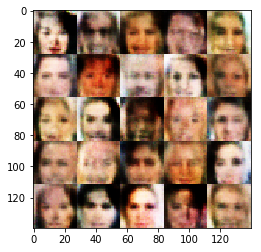

Batch 5010/6331... Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 4.5186
Batch 5020/6331... Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 5.8086
Batch 5030/6331... Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 2.4342
Batch 5040/6331... Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 5.6648
Batch 5050/6331... Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 4.2936
Batch 5060/6331... Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 9.0275
Batch 5070/6331... Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 5.8729
Batch 5080/6331... Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 1.9259
Batch 5090/6331... Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 4.1043
Batch 5100/6331... Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 5.3004


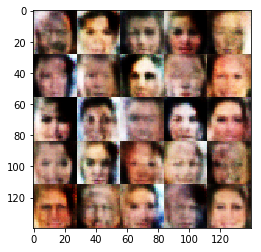

Batch 5110/6331... Epoch 1/1... Discriminator Loss: 0.5784... Generator Loss: 5.1959
Batch 5120/6331... Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 1.2498
Batch 5130/6331... Epoch 1/1... Discriminator Loss: 0.4891... Generator Loss: 7.2145
Batch 5140/6331... Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 5.9156
Batch 5150/6331... Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 3.9261
Batch 5160/6331... Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 3.2596
Batch 5170/6331... Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 5.9887
Batch 5180/6331... Epoch 1/1... Discriminator Loss: 0.4713... Generator Loss: 7.9005
Batch 5190/6331... Epoch 1/1... Discriminator Loss: 0.5144... Generator Loss: 4.7264
Batch 5200/6331... Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 5.7213


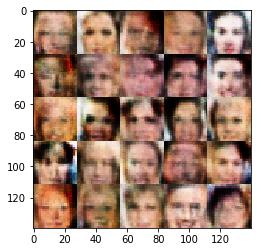

Batch 5210/6331... Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 1.6186
Batch 5220/6331... Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 6.3912
Batch 5230/6331... Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 5.2309
Batch 5240/6331... Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 3.9733
Batch 5250/6331... Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 3.4078
Batch 5260/6331... Epoch 1/1... Discriminator Loss: 0.4841... Generator Loss: 6.7523
Batch 5270/6331... Epoch 1/1... Discriminator Loss: 0.5737... Generator Loss: 2.8232
Batch 5280/6331... Epoch 1/1... Discriminator Loss: 0.6613... Generator Loss: 2.4399
Batch 5290/6331... Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.4762
Batch 5300/6331... Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 1.5368


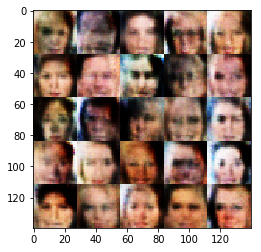

Batch 5310/6331... Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 2.8432
Batch 5320/6331... Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 2.4937
Batch 5330/6331... Epoch 1/1... Discriminator Loss: 0.4887... Generator Loss: 6.5174
Batch 5340/6331... Epoch 1/1... Discriminator Loss: 0.4883... Generator Loss: 5.5759
Batch 5350/6331... Epoch 1/1... Discriminator Loss: 0.5483... Generator Loss: 5.1163
Batch 5360/6331... Epoch 1/1... Discriminator Loss: 0.4823... Generator Loss: 6.9910
Batch 5370/6331... Epoch 1/1... Discriminator Loss: 0.6150... Generator Loss: 2.8369
Batch 5380/6331... Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 3.1399
Batch 5390/6331... Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 8.0222
Batch 5400/6331... Epoch 1/1... Discriminator Loss: 0.5378... Generator Loss: 5.2706


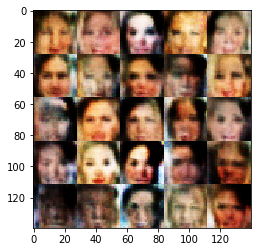

Batch 5410/6331... Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 2.4246
Batch 5420/6331... Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 3.7592
Batch 5430/6331... Epoch 1/1... Discriminator Loss: 0.4862... Generator Loss: 6.7978
Batch 5440/6331... Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 4.4178
Batch 5450/6331... Epoch 1/1... Discriminator Loss: 0.5172... Generator Loss: 3.9920
Batch 5460/6331... Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 5.3476
Batch 5470/6331... Epoch 1/1... Discriminator Loss: 0.4649... Generator Loss: 8.8128
Batch 5480/6331... Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 3.3529
Batch 5490/6331... Epoch 1/1... Discriminator Loss: 0.4774... Generator Loss: 6.7947
Batch 5500/6331... Epoch 1/1... Discriminator Loss: 0.5245... Generator Loss: 4.4048


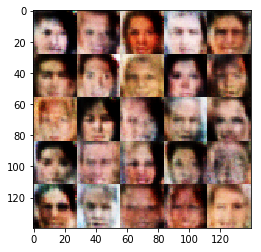

Batch 5510/6331... Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 9.7087
Batch 5520/6331... Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 2.7342
Batch 5530/6331... Epoch 1/1... Discriminator Loss: 0.6597... Generator Loss: 2.0144
Batch 5540/6331... Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 4.3108
Batch 5550/6331... Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 4.7931
Batch 5560/6331... Epoch 1/1... Discriminator Loss: 0.4975... Generator Loss: 5.3346
Batch 5570/6331... Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 2.0220
Batch 5580/6331... Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 3.9000
Batch 5590/6331... Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 2.9776
Batch 5600/6331... Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 5.1588


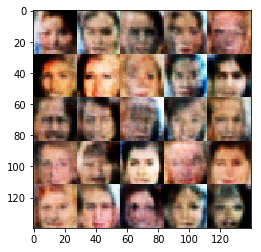

Batch 5610/6331... Epoch 1/1... Discriminator Loss: 0.6296... Generator Loss: 5.7934
Batch 5620/6331... Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 4.5298
Batch 5630/6331... Epoch 1/1... Discriminator Loss: 0.5533... Generator Loss: 3.1782
Batch 5640/6331... Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 5.7624
Batch 5650/6331... Epoch 1/1... Discriminator Loss: 1.9450... Generator Loss: 4.4893
Batch 5660/6331... Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 2.7082
Batch 5670/6331... Epoch 1/1... Discriminator Loss: 0.4858... Generator Loss: 5.5916
Batch 5680/6331... Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 5.7207
Batch 5690/6331... Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 3.9301
Batch 5700/6331... Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 1.6347


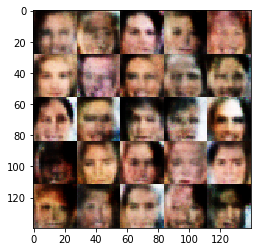

Batch 5710/6331... Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 2.4475
Batch 5720/6331... Epoch 1/1... Discriminator Loss: 0.5130... Generator Loss: 4.7345
Batch 5730/6331... Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 2.5842
Batch 5740/6331... Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 1.1968
Batch 5750/6331... Epoch 1/1... Discriminator Loss: 0.5582... Generator Loss: 3.1108
Batch 5760/6331... Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 2.2284
Batch 5770/6331... Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 2.1108
Batch 5780/6331... Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 5.2724
Batch 5790/6331... Epoch 1/1... Discriminator Loss: 0.5244... Generator Loss: 6.7828
Batch 5800/6331... Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 3.3684


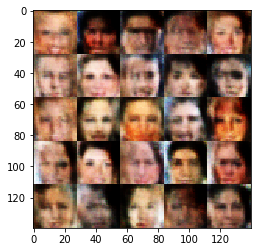

Batch 5810/6331... Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 6.4399
Batch 5820/6331... Epoch 1/1... Discriminator Loss: 0.5406... Generator Loss: 5.7716
Batch 5830/6331... Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 6.5846
Batch 5840/6331... Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 3.5697
Batch 5850/6331... Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 8.8451
Batch 5860/6331... Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 7.0786
Batch 5870/6331... Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 7.5526
Batch 5880/6331... Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 4.5586
Batch 5890/6331... Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 8.6860
Batch 5900/6331... Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.3975


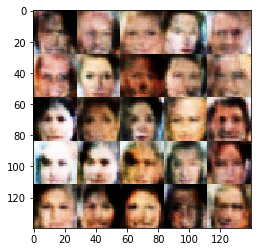

Batch 5910/6331... Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 5.1104
Batch 5920/6331... Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 5.5136
Batch 5930/6331... Epoch 1/1... Discriminator Loss: 0.5119... Generator Loss: 5.3165
Batch 5940/6331... Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.2883
Batch 5950/6331... Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 5.6472
Batch 5960/6331... Epoch 1/1... Discriminator Loss: 0.5780... Generator Loss: 4.9359
Batch 5970/6331... Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 4.9835
Batch 5980/6331... Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.4931
Batch 5990/6331... Epoch 1/1... Discriminator Loss: 0.4757... Generator Loss: 9.5372
Batch 6000/6331... Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 4.7989


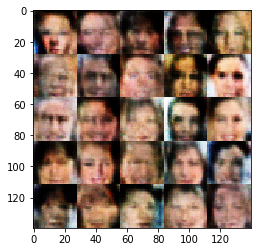

Batch 6010/6331... Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 6.1583
Batch 6020/6331... Epoch 1/1... Discriminator Loss: 0.4991... Generator Loss: 5.6768
Batch 6030/6331... Epoch 1/1... Discriminator Loss: 0.6506... Generator Loss: 2.1623
Batch 6040/6331... Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 1.2486
Batch 6050/6331... Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7300
Batch 6060/6331... Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 4.1647
Batch 6070/6331... Epoch 1/1... Discriminator Loss: 0.6349... Generator Loss: 2.3980
Batch 6080/6331... Epoch 1/1... Discriminator Loss: 0.5144... Generator Loss: 5.2481
Batch 6090/6331... Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 6.8235
Batch 6100/6331... Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 6.7819


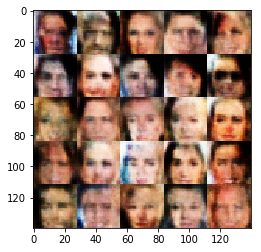

Batch 6110/6331... Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 6.7401
Batch 6120/6331... Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 3.9146
Batch 6130/6331... Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.8279
Batch 6140/6331... Epoch 1/1... Discriminator Loss: 0.5189... Generator Loss: 6.6990
Batch 6150/6331... Epoch 1/1... Discriminator Loss: 0.5229... Generator Loss: 3.8209
Batch 6160/6331... Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 3.7717
Batch 6170/6331... Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 3.8912
Batch 6180/6331... Epoch 1/1... Discriminator Loss: 0.4612... Generator Loss: 10.2251
Batch 6190/6331... Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 8.7550
Batch 6200/6331... Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 2.3184


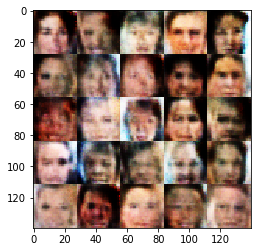

Batch 6210/6331... Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 3.1515
Batch 6220/6331... Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.4694
Batch 6230/6331... Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 3.0267
Batch 6240/6331... Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 5.5342
Batch 6250/6331... Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 2.5248
Batch 6260/6331... Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 1.1809
Batch 6270/6331... Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 3.7161
Batch 6280/6331... Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 4.2878
Batch 6290/6331... Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.1184
Batch 6300/6331... Epoch 1/1... Discriminator Loss: 0.5394... Generator Loss: 4.3297


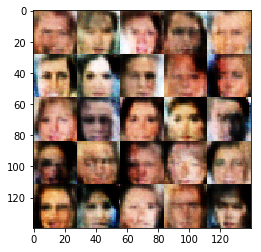

Batch 6310/6331... Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 3.4376
Batch 6320/6331... Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 5.9293
Batch 6330/6331... Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 3.2671


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha=0.2
print_every=10
show_every=100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(
        epochs,
        batch_size,
        z_dim,
        learning_rate,
        beta1,
        celeba_dataset.get_batches,
        celeba_dataset.shape,
        celeba_dataset.image_mode,
        alpha,
        print_every,
        show_every
    )

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.